### Importy Bibliotek

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tensorflow.keras.preprocessing.image import ImageDataGenerator


C:\Users\Tymek\Documents\STUDIA\II - Magister\Sem 2\Uczenie Glebokie\Ships Detection\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
C:\Users\Tymek\Documents\STUDIA\II - Magister\Sem 2\Uczenie Glebokie\Ships Detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Wczytywanie danych

In [2]:
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Tymek\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


<strong>From the datasets author:</strong>
The dataset is also distributed as a JSON formatted text file shipsnet.json. The loaded object contains data, label, scene_ids, and location lists.

In [3]:
file_path = path + '/shipsnet.json'

In [4]:
with open(file_path,'r') as pt:
    df = json.load(pt)
    pt.close()

<strong>From the datasets author:</strong>
The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue.

Po transformacji płaskiej reprezetnacji danych, otrzymujemy 4000 zdjęć, 80x80, 3 kanały.

In [5]:
data = np.array(df['data']).astype('uint8')
img_length = 80
data = data.reshape(4000,3,img_length,img_length).transpose([0,2,3,1])

Warstwa Prawdy



In [6]:
labels = np.array(df['labels']).astype('uint8')
np.unique(labels)

array([0, 1], dtype=uint8)

Label = 0 oznacza "brak statku"
Label = 1 oznacza "statek"

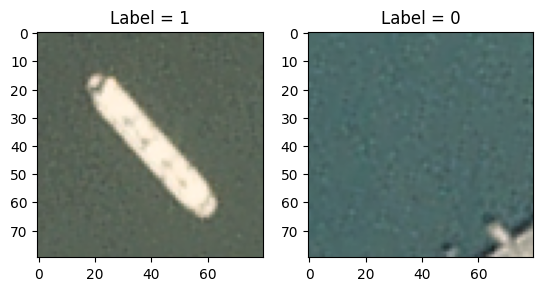

In [7]:
i = 0
fig,ax = plt.subplots(1,2)
ax[0].imshow(data[i])
ax[0].set_title(f"Label = {labels[i]}")
j = 1000
ax[1].imshow(data[j])
ax[1].set_title(f"Label = {labels[j]}")
plt.show()

Podział na zbiór treningowy i walidacyjny

In [8]:
X = data
y = labels

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [9]:
y_train.shape

(3200, 1)

### Model CNN

In [10]:
model = models.Sequential([
    layers.Input(shape=(80, 80, 3)),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(1,activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 97344)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          97,345 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,793 (382.00 KB)

 Trainable params: 97,793 (382.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


Aby uniknąć przeuczenia, używamy earlystopping

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [14]:
h = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=True,
    callbacks=[early_stop]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8069 - loss: 79.8202 - val_accuracy: 0.8838 - val_loss: 6.2636
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9122 - loss: 2.3708 - val_accuracy: 0.9300 - val_loss: 1.1466
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9506 - loss: 0.6372 - val_accuracy: 0.9300 - val_loss: 1.0822
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9581 - loss: 0.3836 - val_accuracy: 0.9538 - val_loss: 0.5116
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9697 - loss: 0.1799 - val_accuracy: 0.9438 - val_loss: 0.5576
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9837 - loss: 0.0733 - val_accuracy: 0.9500 - val_loss: 0.4505
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9881 - loss: 0.0503 - val_accuracy: 0.9500 - val_loss: 0.4507
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9931 - loss: 0.0224 - val_acc

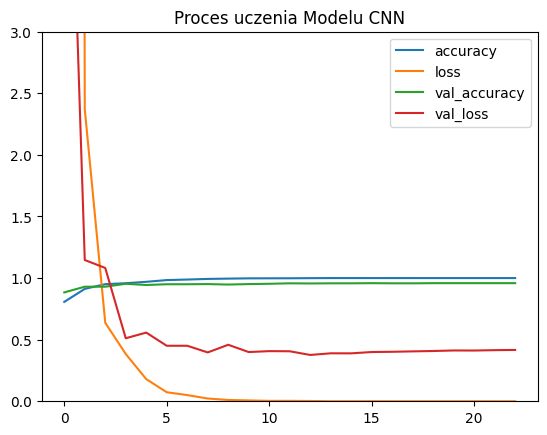

In [15]:
history = pd.DataFrame(h.history)
history.plot()
plt.title("Proces uczenia Modelu CNN")
plt.ylim(0,3)
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_probs = model.predict(X_val).flatten()

y_pred = (y_pred_probs > 0.5).astype("int32")

y_true = y_val.flatten()

cm = confusion_matrix(y_pred, y_true)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


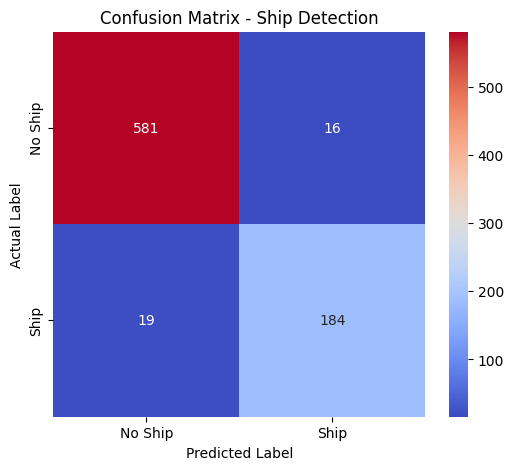

In [17]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['No Ship', 'Ship'],
            yticklabels=['No Ship', 'Ship'])

plt.title('Confusion Matrix - Ship Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
metrics_1 = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-Score": f1_score(y_true, y_pred, average='weighted')
}

for name, value in metrics_1.items():
    print(f"{name}: {value:.4f}")

Accuracy: 0.9563
Precision: 0.9565
Recall: 0.9563
F1-Score: 0.9564


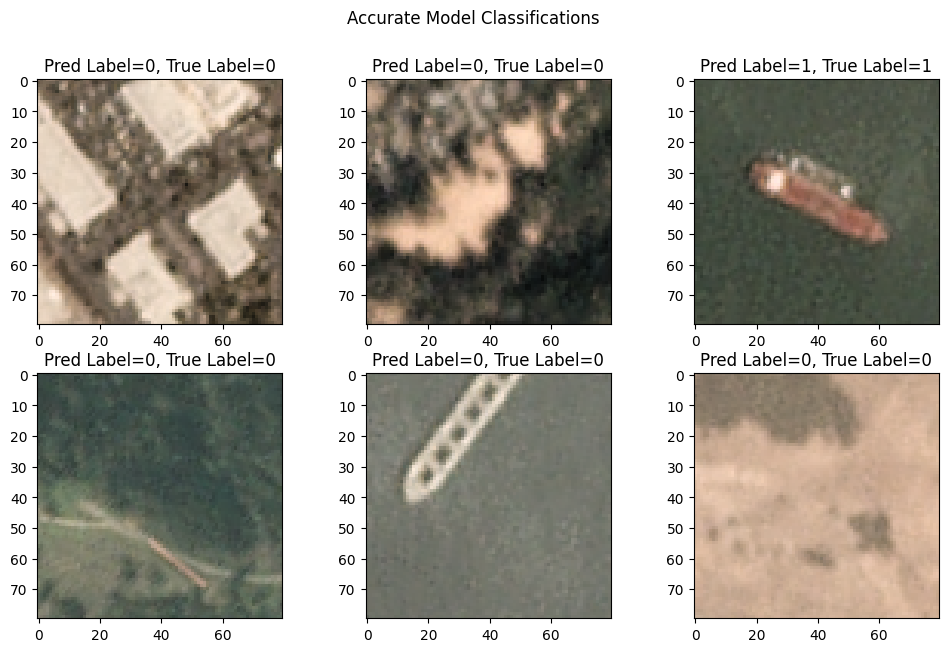

In [19]:
start = 0
rows = 2
cols = 3
fig, ax = plt.subplots(rows,cols,figsize=(12,7))
fig.suptitle("Accurate Model Classifications")
for i,image in enumerate(X_val[start:start + rows*cols]):
    row = i // cols
    col = i % cols

    ax[row,col].imshow(image)
    ax[row,col].set_title(f'Pred Label={y_pred[start+i]}, True Label={y_true[start+i]}')

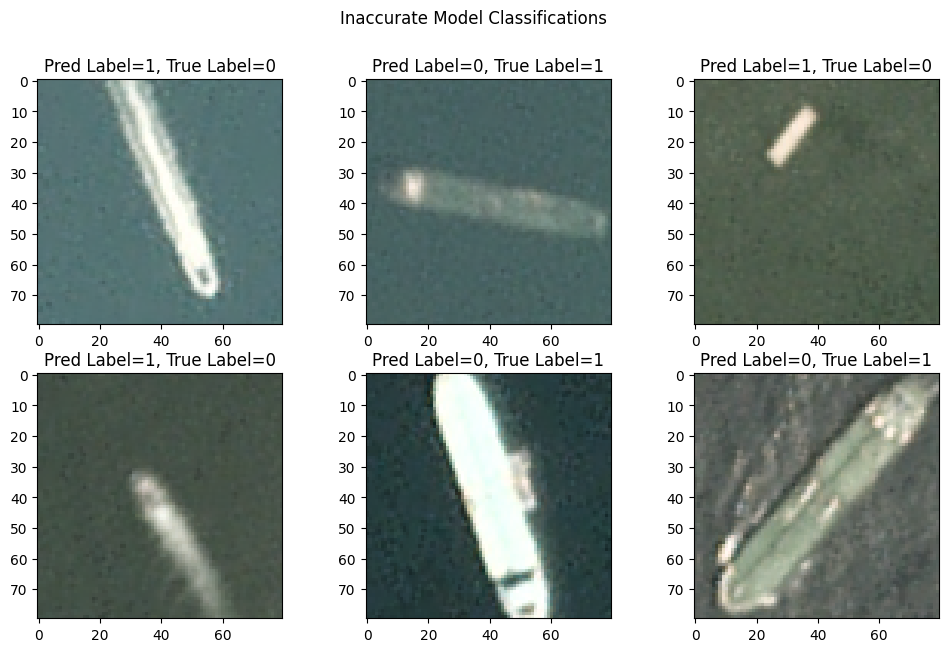

In [20]:
wrong_classification_indices = np.where(y_pred != y_true)[0]
rows = 2
cols = 3
fig, ax = plt.subplots(rows,cols,figsize=(12,7))
fig.suptitle("Inaccurate Model Classifications")
for i in range(rows*cols):
    row = i // cols
    col = i % cols
    ax[row,col].imshow(X_val[wrong_classification_indices[i]])
    ax[row,col].set_title(f'Pred Label={y_pred[wrong_classification_indices[i]]}, True Label={y_true[wrong_classification_indices[i]]}')

### Model CNN z Augmentacją Danych

In [21]:
def cloud_preprocessing(img):

    intensity = np.random.uniform(0.2, 0.5) 
    blur_sigma = np.random.uniform(3, 7)

    noise = np.random.rand(80, 80)


    clouds = gaussian_filter(noise, sigma=blur_sigma)

    clouds = (clouds - clouds.min()) / (clouds.max() - clouds.min())

    clouds = np.where(clouds > (1 - intensity), clouds, 0)

    clouds_3d = np.stack([clouds]*3, axis=-1)

    img_with_clouds = img * (1 - clouds_3d) + clouds_3d
    img_with_clouds = img_with_clouds.astype('uint8')

    return np.clip(img_with_clouds, 0, 255)

img_index = 2
img_cloudy = cloud_preprocessing(X_val[img_index])

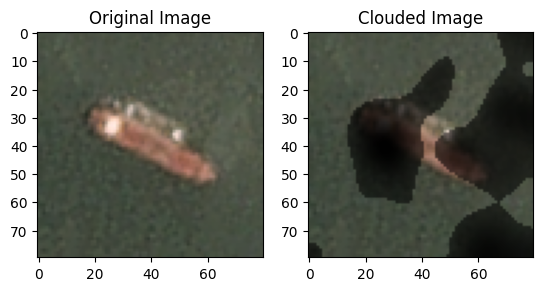

In [22]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(X_val[img_index])
ax[0].set_title("Original Image")
ax[1].imshow(img_cloudy)
ax[1].set_title("Clouded Image")
plt.show()

In [23]:
# Konfiguracja generatora
datagen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=cloud_preprocessing 
)

model_v2 = models.Sequential([
    layers.Input(shape=(80, 80, 3)),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(1,activation='sigmoid')
])

model_v2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Uruchomienie treningu
h = model_v2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val), # Walidacja pozostaje bez chmur
    epochs=30,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.7428 - loss: 51.8992 - val_accuracy: 0.8050 - val_loss: 0.6944
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8416 - loss: 0.7144 - val_accuracy: 0.8150 - val_loss: 0.5237
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8397 - loss: 0.5286 - val_accuracy: 0.8512 - val_loss: 0.4188
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8447 - loss: 0.4466 - val_accuracy: 0.8550 - val_loss: 0.3926
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8466 - loss: 0.4280 - val_accuracy: 0.8650 - val_loss: 0.4067
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8569 - loss: 0.3842 - val_accuracy: 0.8600 - val_loss: 0.3769
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8475 - loss: 0.4041 - val_accuracy: 0.8800 - val_loss: 0.3608
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.8572 - loss: 0.3718 - val_acc

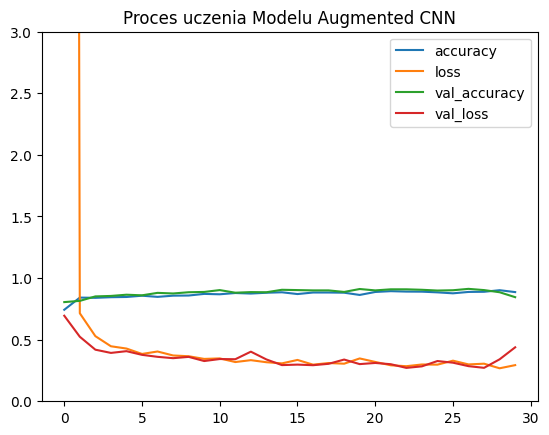

In [24]:
history_2 = pd.DataFrame(h.history)
history_2.plot()
plt.title("Proces uczenia Modelu Augmented CNN")
plt.ylim(0,3)
plt.show()

In [25]:
y_pred_probs = model_v2.predict(X_val).flatten()

y_pred = (y_pred_probs > 0.5).astype("int32")

y_true = y_val.flatten()

cm = confusion_matrix(y_pred, y_true)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


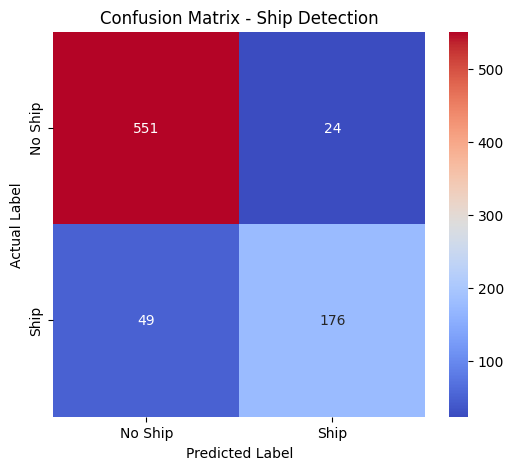

In [26]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['No Ship', 'Ship'],
            yticklabels=['No Ship', 'Ship'])

plt.title('Confusion Matrix - Ship Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [27]:
metrics_2 = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-Score": f1_score(y_true, y_pred, average='weighted')
}

for name, value in metrics_2.items():
    print(f"{name}: {value:.4f}")

Accuracy: 0.9087
Precision: 0.9143
Recall: 0.9087
F1-Score: 0.9105


### Deep Model CNN

Pomimo bardzo wysokiej jakości klasyfikacji przez model bazowy, rozwinięto go o dodatkowe warstwy.

Celem było sprawdzenie czy można osiągnąć jeszcze większą dokładność, kosztem wielkości modelu i czasu treningu.

In [28]:
model_v3 = models.Sequential([
    layers.Input(shape=(80, 80, 3)),


    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [29]:
model_v3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 80, 80, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_v3.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [31]:
h = model_v3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=True,
    callbacks=[early_stop]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.8653 - loss: 2.4893 - val_accuracy: 0.9187 - val_loss: 0.2100
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9303 - loss: 0.1932 - val_accuracy: 0.9450 - val_loss: 0.1473
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9419 - loss: 0.1663 - val_accuracy: 0.9563 - val_loss: 0.1357
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9519 - loss: 0.1307 - val_accuracy: 0.9650 - val_loss: 0.1066
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9694 - loss: 0.0841 - val_accuracy: 0.9650 - val_loss: 0.0930
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9778 - loss: 0.0674 - val_accuracy: 0.9638 - val_loss: 0.1189
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9663 - loss: 0.0923 - val_accuracy: 0.9800 - val_loss: 0.0625
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9819 - loss: 0.0489 - val_ac

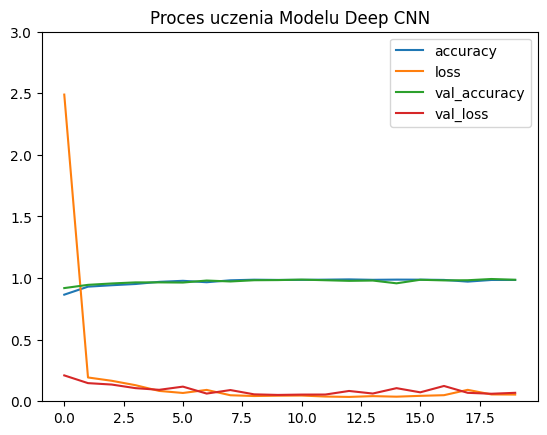

In [32]:
import pandas as pd

history_2 = pd.DataFrame(h.history)
history_2.plot()
plt.title("Proces uczenia Modelu Deep CNN")
plt.ylim(0,3)
plt.show()

In [33]:
model_v3.save('models/deep_model.keras')

In [34]:
saved_model = keras.models.load_model('models/deep_model.keras')

In [35]:
saved_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 80, 80, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,195,717 (19.82 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,463,812 (13.21 MB)

In [36]:
y_pred_probs = saved_model.predict(X_val).flatten()

y_pred = (y_pred_probs > 0.5).astype("int32")

y_true = y_val.flatten()

cm = confusion_matrix(y_pred, y_true)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


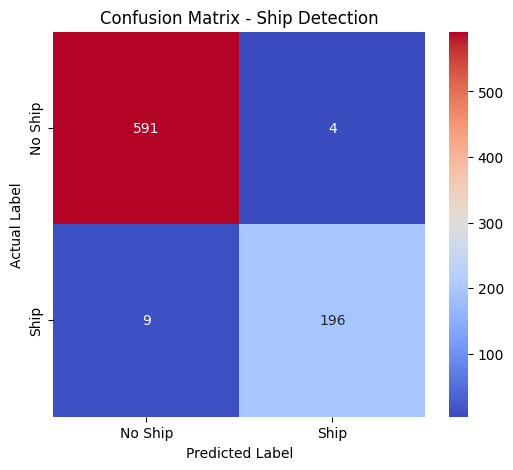

In [37]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['No Ship', 'Ship'],
            yticklabels=['No Ship', 'Ship'])

plt.title('Confusion Matrix - Ship Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [38]:
metrics_3 = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1-Score": f1_score(y_true, y_pred, average='weighted')
}

for name, value in metrics_3.items():
    print(f"{name}: {value:.4f}")

Accuracy: 0.9838
Precision: 0.9840
Recall: 0.9838
F1-Score: 0.9838


In [ ]:
from IPython.display import Markdown, display

df = pd.DataFrame({
    "Model CNN Podstawowy": metrics_1,
    "Model CNN z Augmentacją Danych": metrics_2,
    "Model CNN Głęboki": metrics_3
})

# Wyświetlamy jako Markdown
tabela_md = f"""
### Porównanie Wyników Klasyfikacji
{df.to_markdown(floatfmt=".4f")}
"""

display(Markdown(tabela_md))

In [41]:
np.where(y_pred != y_true)[0]

array([ 12,  37, 102, 104, 121, 133, 277, 370, 382, 427, 508, 649, 728])

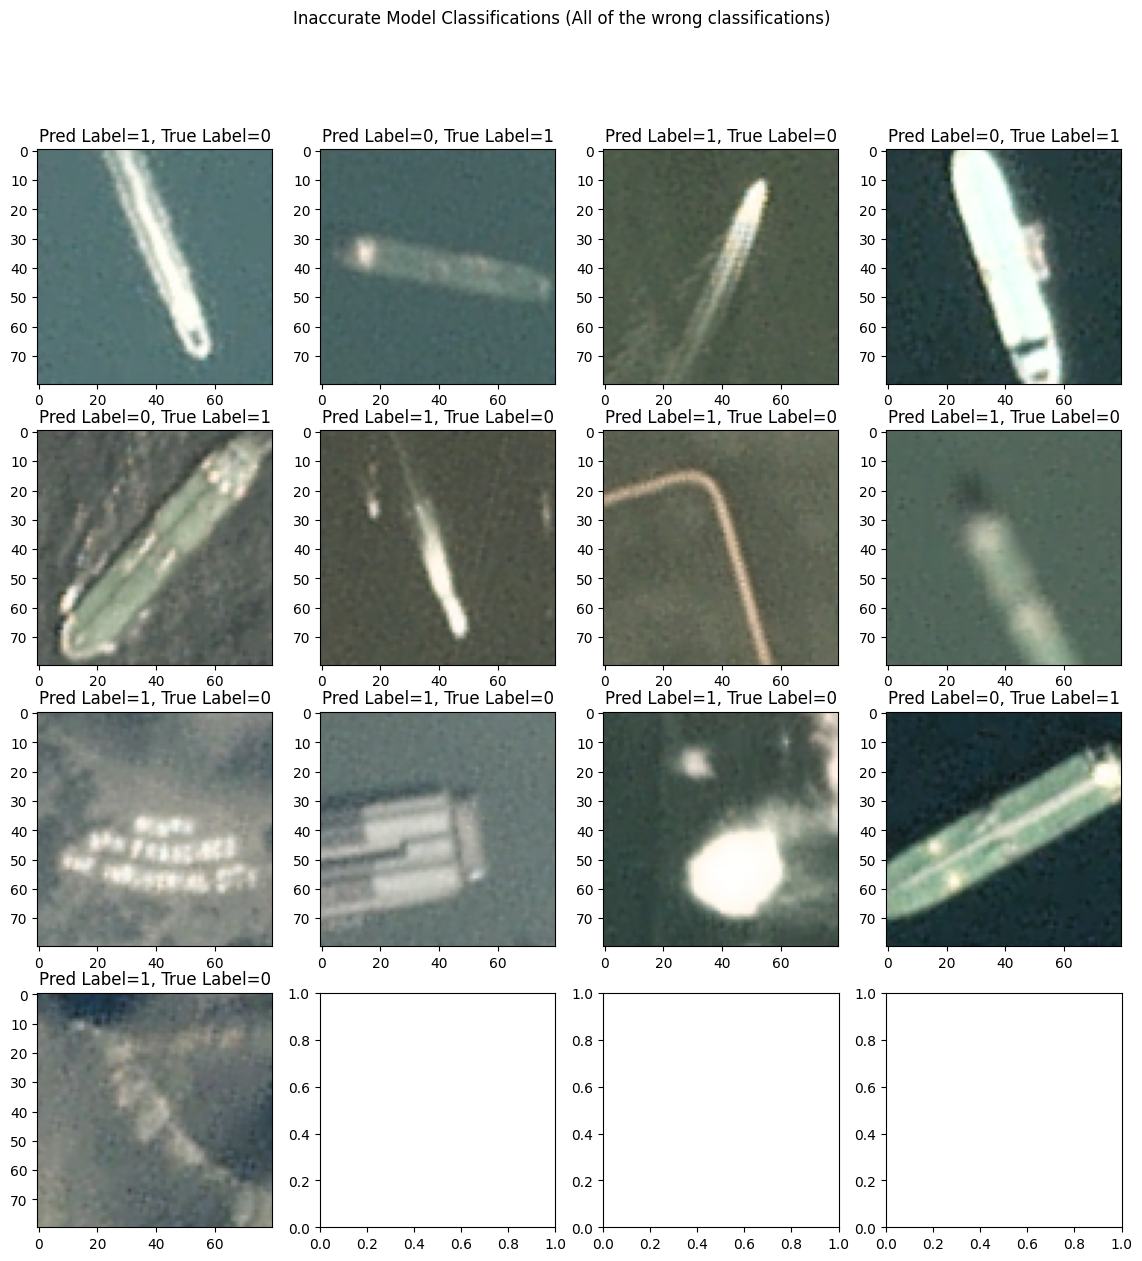

In [43]:
wrong_classification_indices = np.where(y_pred != y_true)[0]
rows = 4
cols = 4

fig, ax = plt.subplots(rows,cols,figsize=(14,14))
fig.suptitle("Inaccurate Model Classifications (All of the wrong classifications)")
for i in range(rows*cols):
    row = i // cols
    col = i % cols
    if len(wrong_classification_indices) <= i:
        break
    ax[row,col].imshow(X_val[wrong_classification_indices[i]])
    ax[row,col].set_title(f'Pred Label={y_pred[wrong_classification_indices[i]]}, True Label={y_true[wrong_classification_indices[i]]}')

### Porównanie Wyników Klasyfikacji Modeli CNN

| Metryka / Model | Model CNN Podstawowy | Model CNN z Augmentacją Danych | Model CNN Głęboki |
| :--- | :--- | :--- | :--- |
| **Komentarz** | Model bazowy, szybki w trenowaniu. Tylko na oryginalnych danych osiągał bardzo dobre wyniki > 0.9 dla wszystkich metryk|  Model bazowy, na danych augmentowanych. W teorii powinien osiągnąć lepsze wyniki niż poprzedni, aczkolwiek wszystkie metryki spadły, może sposób augmentacji został źle dobrany, jest również szansa, ze metryki spadły ale na danych przy zlej pogodzie radziłby sobie lepiej | Najlepsze metryki, bliskie perfekcyjnych - jest to kosztem długiego czasu trenowania i dużego rozmiaru modelu.


### Komentarze do Modeli i ich wyników

| Metryka / Model | Model CNN Podstawowy | Model CNN z Augmentacją Danych | Model CNN Głęboki |
| :--- | :--- | :--- | :--- |
| **Komentarz** | Model bazowy, szybki w trenowaniu. Tylko na oryginalnych danych osiągał bardzo dobre wyniki > 0.9 dla wszystkich metryk|  Model bazowy, na danych augmentowanych. W teorii powinien osiągnąć lepsze wyniki niż poprzedni, aczkolwiek wszystkie metryki spadły, może sposób augmentacji został źle dobrany, jest również szansa, ze metryki spadły ale na danych przy zlej pogodzie radziłby sobie lepiej | Najlepsze metryki, bliskie perfekcyjnych - jest to kosztem długiego czasu trenowania i dużego rozmiaru modelu. Tylko kilkanaście na kilkaset obrazów zostało niepoprawnie zaklasyfikowanych